In [4]:
import pandas as pd
import unicodedata

In [5]:
dev_df = pd.read_csv('../data/dev_data.csv', encoding="utf8")
test_df = pd.read_csv('../data/test_data_with_label.csv', encoding="utf8")

In [6]:
import unicodedata
def reencode_and_normalize(text):
    transl_table = dict([(ord(x), ord(y)) for x,y in zip( u"‘’´“”–-",  u"'''\"\"--")])
    fixed_text = text.replace('鈥�', '"').replace('鉂�', '').encode('gb18030').decode('utf8')
    fixed_text = unicodedata.normalize("NFKD", fixed_text)
    fixed_text = fixed_text.translate(transl_table)
    return fixed_text

test_df['Text data'] = test_df['Text data'].apply(reencode_and_normalize)

In [7]:
test_df['Text data'] = test_df['Text data'].str.strip()
dev_df['text data'] = dev_df['text data'].str.strip()

In [8]:
test_texts = list(test_df['Text data'].values)
dev_texts = list(dev_df['text data'].values)

In [9]:
best_models = {
    'roberta-large-v3-maxlen': 'hypsearch/output/roberta-large-v3-maxlen/trial_4',
    'roberta-mental-health-v3-maxlen': 'hypsearch/output/roberta-mental-health-v3-maxlen/trial_22',
    'deberta-large-v3-maxlen': 'hypsearch/output/deberta-large-v3-maxlen/trial_25',
    'deberta-mental-health-v3': 'hypsearch/output/deberta-mental-health-v3_2/trial_57',
    
    'roberta-mental-health-headtail-0': 'hypsearch/output/roberta-mental-health-v5-tail/trial_2',
    'roberta-mental-health-headtail-25': 'hypsearch/output/roberta-mental-health-v4-headtail/trial_8',
    'roberta-mental-health-headtail-50': 'hypsearch/output/roberta-mental-health-v4-headtail/trial_21',
    'roberta-mental-health-headtail-75': 'hypsearch/output/roberta-mental-health-v4-headtail/trial_2',
    
    'oll-roberta-mental-health-v2-fixloss': 'hypsearch/output/oll-roberta-mental-health-v2-fixloss/trial_25',
    'roberta-mental-health-v6-labelsmoothing': 'hypsearch/output/roberta-mental-health-v6-labelsmoothing/trial_49',
    'regression-v2': 'hypsearch/output/regression-v2/trial_50',
    'corn': 'hypsearch/output/corn-roberta-mental-health-v2/trial_14'
}

In [10]:
id2label = {
    0:"not depression",
    1:"moderate",
    2:"severe"
}

label2id = {v: k for k, v in id2label.items()}

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from hypsearch.coral import CoralRobertaForSequenceClassification
import torch
import os
import json

def load_model(model_path):
    with open(os.path.join(model_path, 'config.json'), 'r') as f:
        config = json.load(f)
    if 'class_regression' in config and config['class_regression']:
        model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)
    elif ('corn_model' in config or 'coral_model' in config) and (config['corn_model'] or config['coral_model']):
        model = CoralRobertaForSequenceClassification.from_pretrained(model_path)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

#model, tokenizer = load_model('hypsearch/output/roberta-large-v3-maxlen/trial_4')
#model = model.to(device)

In [12]:
import torch.nn.functional as F
from hypsearch.coral import proba_to_label_np, corn_label_from_logits_np
import numpy as np
import gc

def predict(texts, model, tokenizer, batchsize=64, device=torch.device('cpu'), max_seq_length=512):
    all_logits = []
    for i in range(0, len(texts), batchsize):
        #print(len(all_logits), len(texts)//batchsize)
        batch = texts[i:i+batchsize]
        
        max_head_limit = None
        if hasattr(model.config, 'max_head_limit'):
            max_head_limit = model.config.max_head_limit
            
        if max_head_limit is None:
            inputs = tokenizer(batch, truncation=True, padding=True, return_tensors='pt', max_length=max_seq_length).to(device)
        else:
            head_limit = max_head_limit
            if isinstance(head_limit, float):
                head_limit = round(max_seq_length*head_limit)
                if head_limit == 0:
                    head_limit = 1
            #print('head_limit', head_limit)
            inputs = {
                'input_ids': [],
                'attention_mask': []
            }
            tokenized_dataset = tokenizer(batch, padding=True, truncation=False)
            token_to_find = tokenizer.sep_token_id
            for tokens, attention_mask in zip(tokenized_dataset['input_ids'], tokenized_dataset['attention_mask']):
                size = tokens.index(token_to_find) + 1
                if size > max_seq_length:
                    inputs['input_ids'].append(tokens[:head_limit]+ tokens[size-max_seq_length+head_limit:size])
                    inputs['attention_mask'].append(attention_mask[:head_limit]+ attention_mask[size-max_seq_length+head_limit:size])
                else:
                    inputs['input_ids'].append(tokens[:max_seq_length])
                    inputs['attention_mask'].append(attention_mask[:max_seq_length])
            inputs['input_ids'] = torch.tensor(inputs['input_ids'], dtype=torch.long, device=device)
            inputs['attention_mask'] = torch.tensor(inputs['attention_mask'], dtype=torch.long, device=device)

        with torch.no_grad():
            outputs = model(**inputs)

        all_logits.append(outputs.logits.detach().cpu())
        
        del inputs
        del outputs
    
    all_logits = torch.cat(all_logits)
    softmax = F.softmax(all_logits, dim=-1).numpy()
    all_logits = all_logits.numpy()
    
    if (hasattr(model.config, 'class_regression') and model.config.class_regression) or (hasattr(model.config, 'problem_type') and model.config.problem_type == "regression"):
        soft_preds = np.squeeze(all_logits)
        preds = np.clip(np.round(soft_preds).astype(int), 0, len(label2id)-1) 
        logits_output = np.eye(len(label2id))[preds]
        softmax_output = logits_output.copy()
    elif (hasattr(model.config, 'corn_model') and model.config.corn_model):
        preds = corn_label_from_logits_np(all_logits)
        soft_preds = preds.copy()
        logits_output = np.eye(len(label2id))[preds]
        softmax_output = logits_output.copy()
    elif (hasattr(model.config, 'coral_model') and model.config.coral_model):
        return None
    else:
        remap_labels = []
        for label in label2id:
            remap_labels.append(model.config.label2id[label])
        logits_output = all_logits[:, remap_labels].copy()
        softmax_output = softmax[:, remap_labels].copy()
        preds = softmax_output.argmax(-1)
        
        #soft preds
        #[0.7, 0.1, 0.2] -> (0 + 0.1 + 0.2) -> 0.3
        #[0.1, 0.7, 0.2] -> (1 - 0.1 + 0.2) -> 1.1
        #[0.1, 0.2, 0.7] -> (2 - 0.1 - 0.2) -> 1.7
        
        #[0.3, 0.3, 0.4] -> (2 - 0.3 - 0.3) -> 1.4 .round() -> 1 #error
        #[0.3333, 0.333, 0.33..4] -> lower bound
        #[0.49, 0.0, 0.51] -> (2 - 0.49 - 0.0) -> 1.51 .round() -> 2
        dist_mask = np.array([
            [0, 1, 1],
            [-1, 0, 1],
            [-1, -1, 0]
        ])

        soft_preds = preds + np.clip(np.sum(dist_mask[preds] * softmax_output, axis=-1), -0.499, 0.499)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds, soft_preds, softmax_output, logits_output

In [13]:
device = torch.device('cuda:7')
outputs = []
for model_name in best_models:
    print(model_name)
    model_path = best_models[model_name]
    
    model, tokenizer = load_model(model_path)
    model = model.to(device)
    model_outputs = predict(dev_texts, model, tokenizer, batchsize=128, device=device)
    outputs.append(model_outputs)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()

roberta-large-v3-maxlen


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


roberta-mental-health-v3-maxlen
deberta-large-v3-maxlen
deberta-mental-health-v3
roberta-mental-health-headtail-0


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


roberta-mental-health-headtail-25


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


roberta-mental-health-headtail-50


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


roberta-mental-health-headtail-75


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


oll-roberta-mental-health-v2-fixloss


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


roberta-mental-health-v6-labelsmoothing


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


regression-v2


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


corn


Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors


In [14]:
import pickle
with open('ensemble_outputs.pickle', 'wb') as f:
    pickle.dump(outputs, f)

In [15]:
gc.collect()
torch.cuda.empty_cache()

In [16]:
y_true = dev_df['label'].map(label2id).values

In [17]:
from sklearn.metrics import f1_score
import numpy as np
from scipy import stats

preds = np.asarray([o[0] for o in outputs])
soft_preds = np.asarray([o[1] for o in outputs])
softmax = np.asarray([o[2] for o in outputs])
logits = np.asarray([o[3] for o in outputs])

In [18]:
model_scores = []
for y_pred in preds:
    model_scores.append(f1_score(y_true, y_pred, average="macro"))
model_scores = np.asarray(model_scores)

In [19]:
def ordered_mean(preds):
    #map_ordered = {0:1, 1:0, 2:2}
    #unmap_ordered = {1:0, 0:1, 2:2}
    
    pred_ordered = preds#np.vectorize(lambda x: map_ordered[x])(preds)
    pred_ordered_mean = np.mean(pred_ordered, axis=0).round()
    #pred_ordered_mean_unmap = np.vectorize(lambda x: unmap_ordered[x])(pred_ordered_mean)
    return pred_ordered

def softmax_to_scalar_mean(softmax):
    #[0.7, 0.1, 0.2] -> (0 + 0.1 + 0.2) -> 0.3
    #[0.1, 0.7, 0.2] -> (1 - 0.1 + 0.2) -> 1.1
    #[0.1, 0.2, 0.7] -> (2 - 0.1 - 0.2) -> 1.7
    
    #[0.49, 0.0, 0.51] -> (2 - 0.49 - 0.0) -> 1.51 .round() -> 2
    #map_ordered = [1,0,2]
    #unmap_ordered = {1:0, 0:1, 2:2}
    dist_mask = np.array([
        [0, 1, 1],
        [-1, 0, 1],
        [-1, -1, 0]
    ])
    
    #map_ordered = [1,0,2]
    softmax_ordered = softmax#[:, :, map_ordered]
    preds_ordered = softmax_ordered.argmax(-1)
    scalar_labels = preds_ordered + np.sum(dist_mask[preds_ordered] * softmax_ordered, axis=-1)
    scalar_labels_mean = np.mean(scalar_labels, axis=0).round()
    #scalar_labels_mean_unmap = np.vectorize(lambda x: unmap_ordered[x])(scalar_labels_mean)
    return scalar_labels_mean#_unmap

In [20]:
score_sort = np.flip(model_scores.argsort())
all_scores = []
for i in range(len(score_sort)):
    i = i+1
    print(i)
    temp_results = {
        "softmax_mean_preds": np.mean(softmax[score_sort][:i], axis=0).argmax(-1),
        "softmax_max_preds": np.max(softmax[score_sort][:i], axis=0).argmax(-1),
        "logits_mean_preds": np.mean(logits[score_sort][:i], axis=0).argmax(-1),
        "logits_max_preds": np.max(logits[score_sort][:i], axis=0).argmax(-1),
        "preds_mode": stats.mode(preds[score_sort][:i], axis=0).mode[0],
        "preds_ordered_mean": np.mean(preds[score_sort][:i], axis=0).round(),
        "softmax_to_scalar_mean": np.mean(soft_preds[score_sort][:i], axis=0).round()
    }
    i_scores = {'i': i}
    for r in temp_results:
        i_scores[r] = f1_score(y_true, temp_results[r], average="macro")
    
    all_scores.append(i_scores)

1
2
3
4
5
6
7
8
9
10
11
12


In [21]:
(preds[score_sort[0]] != soft_preds[score_sort[0]].round()).sum()

0

In [22]:
preds[score_sort[0]][(preds[score_sort[0]] != soft_preds[score_sort[0]].round())]

array([], dtype=int64)

In [23]:
soft_preds[score_sort[0]][(preds[score_sort[0]] != soft_preds[score_sort[0]].round())]

array([], dtype=float64)

In [24]:
import pandas as pd
df_scores = pd.DataFrame(all_scores)
df_scores.max().sort_values(ascending=False)

i                         12.000000
preds_ordered_mean         0.616459
preds_mode                 0.613477
softmax_to_scalar_mean     0.605563
softmax_mean_preds         0.604406
logits_mean_preds          0.602459
logits_max_preds           0.595776
softmax_max_preds          0.593982
dtype: float64

In [25]:
df_scores.mean().sort_values(ascending=False)

i                         6.500000
preds_ordered_mean        0.605710
preds_mode                0.603565
softmax_to_scalar_mean    0.601833
softmax_mean_preds        0.598777
logits_mean_preds         0.597964
softmax_max_preds         0.589766
logits_max_preds          0.584376
dtype: float64

In [26]:
df_scores

,i,softmax_mean_preds,softmax_max_preds,logits_mean_preds,logits_max_preds,preds_mode,preds_ordered_mean,softmax_to_scalar_mean
0,1,0.593982,0.593982,0.593982,0.593982,0.593982,0.593982,0.593982
1,2,0.592261,0.592261,0.591864,0.595776,0.598089,0.591414,0.596315
2,3,0.604406,0.592261,0.595936,0.584727,0.609223,0.608227,0.598572
3,4,0.601786,0.592261,0.596753,0.585579,0.606778,0.609412,0.605563
4,5,0.601783,0.592261,0.599133,0.584756,0.613477,0.616459,0.605318
5,6,0.600588,0.592261,0.602459,0.586288,0.605748,0.610771,0.604332
6,7,0.600801,0.592261,0.599964,0.583080,0.606795,0.609272,0.603021
7,8,0.600043,0.585928,0.601495,0.583393,0.601148,0.607398,0.604083
8,9,0.599157,0.585928,0.599088,0.582382,0.603875,0.608387,0.603467
9,10,0.599809,0.585928,0.599894,0.579655,0.600632,0.607880,0.602363


In [33]:
df_scores.set_index('i')[['softmax_mean_preds', 'preds_ordered_mean', 'preds_mode']] \
    .rename(columns={'softmax_mean_preds': 'Softmax Mean',
             'preds_ordered_mean': 'Mean', 
             'preds_mode': 'Voting'})\
    .rename_axis('Number of Models')

,Softmax Mean,Mean,Voting
Number of Models,,,
1,0.593982,0.593982,0.593982
2,0.592261,0.591414,0.598089
3,0.604406,0.608227,0.609223
4,0.601786,0.609412,0.606778
5,0.601783,0.616459,0.613477
6,0.600588,0.610771,0.605748
7,0.600801,0.609272,0.606795
8,0.600043,0.607398,0.601148
9,0.599157,0.608387,0.603875


<AxesSubplot:xlabel='Number of Models', ylabel='Macro F1-Score (dev set)'>

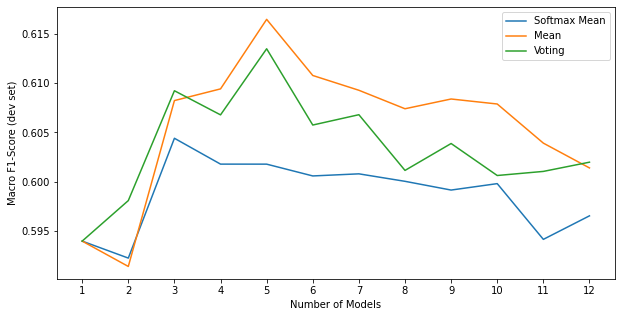

In [41]:
df_scores.set_index('i')[['softmax_mean_preds', 'preds_ordered_mean', 'preds_mode']] \
    .rename(columns={'softmax_mean_preds': 'Softmax Mean',
             'preds_ordered_mean': 'Mean', 
             'preds_mode': 'Voting'})\
    .rename_axis('Number of Models') \
    .plot(figsize=(10, 5),
          xticks=df_scores['i'].values,
          ylabel="Macro F1-Score")

In [27]:
results = {
    "softmax_mean_preds": np.mean(softmax, axis=0).argmax(-1),
    "softmax_max_preds": np.max(softmax, axis=0).argmax(-1),
    "logits_mean_preds": np.mean(logits, axis=0).argmax(-1),
    "logits_max_preds": np.max(logits, axis=0).argmax(-1),
    "preds_mode": stats.mode(preds, axis=0).mode[0],
    "preds_ordered_mean": np.mean(preds, axis=0).round(),
    "softmax_to_scalar_mean": np.mean(soft_preds, axis=0).round()
}

In [28]:
scores = {}
for r in results:
    scores[r] = f1_score(y_true, results[r], average="macro")
dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

{'softmax_to_scalar_mean': 0.6026982945631749,
 'preds_mode': 0.6019824907294249,
 'preds_ordered_mean': 0.6014000676529339,
 'softmax_mean_preds': 0.5965442318797802,
 'logits_mean_preds': 0.5955522998660151,
 'softmax_max_preds': 0.5859278874731021,
 'logits_max_preds': 0.5745068159059707}